# Skin Lesion Classification — Transfer Learning
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```

**Model:** EfficientNet-B0

In [1]:
# Environment & imports
# Install PyTorch with CUDA support (run this cell first if CUDA is not available)
# Your system has CUDA 12.7, so use cu124 (compatible with CUDA 12.x):
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Alternative for CUDA 12.1:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install other packages
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Force GPU usage
if not torch.cuda.is_available():
    print("CUDA not available. Installing CPU version of PyTorch...")
    # Install CPU version if GPU not available
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    device = torch.device("cpu")
    print("Using CPU. To use GPU, install CUDA and PyTorch with CUDA support.")
else:
    device = torch.device("cuda")
    print("Device:", device)
    print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "N/A")

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Device: cuda
CUDA version: 12.4
Device: cuda
CUDA version: 12.4


In [2]:
# Paths (change these to your dataset locations)
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [3]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')
tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [4]:
# EfficientNet-B0 (torchvision if available)
try:
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # If torchvision doesn't have efficientnet in your environment, use timm (uncomment install if needed)
    # !pip install timm -q
    import timm
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)


c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 30  # change as needed


In [6]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [7]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="EfficientNet-B0")


Epoch 1/30


100%|██████████| 333/333 [01:52<00:00,  2.96it/s]


train Loss: 1.3760 Acc: 0.4802 F1: 0.4579


100%|██████████| 42/42 [00:09<00:00,  4.48it/s]


val Loss: 0.8272 Acc: 0.7023 F1: 0.7067
------------------------------
Epoch 2/30


100%|██████████| 333/333 [01:33<00:00,  3.54it/s]


train Loss: 0.7536 Acc: 0.6805 F1: 0.6718


100%|██████████| 42/42 [00:09<00:00,  4.57it/s]


val Loss: 0.5120 Acc: 0.8169 F1: 0.8091
------------------------------
Epoch 3/30


100%|██████████| 333/333 [01:41<00:00,  3.27it/s]


train Loss: 0.5928 Acc: 0.7514 F1: 0.7383


100%|██████████| 42/42 [00:08<00:00,  4.92it/s]


val Loss: 0.4097 Acc: 0.8440 F1: 0.8263
------------------------------
Epoch 4/30


100%|██████████| 333/333 [01:46<00:00,  3.14it/s]


train Loss: 0.4954 Acc: 0.7917 F1: 0.7783


100%|██████████| 42/42 [00:08<00:00,  5.07it/s]


val Loss: 0.2965 Acc: 0.8960 F1: 0.8834
------------------------------
Epoch 5/30


100%|██████████| 333/333 [01:45<00:00,  3.16it/s]


train Loss: 0.4412 Acc: 0.8141 F1: 0.8019


100%|██████████| 42/42 [00:08<00:00,  5.06it/s]


val Loss: 0.2644 Acc: 0.9035 F1: 0.8935
------------------------------
Epoch 6/30


100%|██████████| 333/333 [01:40<00:00,  3.30it/s]


train Loss: 0.3976 Acc: 0.8368 F1: 0.8243


100%|██████████| 42/42 [00:08<00:00,  5.14it/s]


val Loss: 0.2276 Acc: 0.9126 F1: 0.9034
------------------------------
Epoch 7/30


100%|██████████| 333/333 [01:48<00:00,  3.06it/s]


train Loss: 0.3657 Acc: 0.8494 F1: 0.8381


100%|██████████| 42/42 [00:08<00:00,  4.71it/s]


val Loss: 0.1891 Acc: 0.9239 F1: 0.8996
------------------------------
Epoch 8/30


100%|██████████| 333/333 [01:35<00:00,  3.49it/s]


train Loss: 0.3325 Acc: 0.8626 F1: 0.8514


100%|██████████| 42/42 [00:07<00:00,  5.39it/s]


val Loss: 0.1832 Acc: 0.9314 F1: 0.8906
------------------------------
Epoch 9/30


100%|██████████| 333/333 [01:35<00:00,  3.49it/s]


train Loss: 0.3053 Acc: 0.8748 F1: 0.8611


100%|██████████| 42/42 [00:08<00:00,  5.23it/s]


val Loss: 0.1974 Acc: 0.9261 F1: 0.9061
------------------------------
Epoch 10/30


100%|██████████| 333/333 [01:31<00:00,  3.64it/s]


train Loss: 0.2884 Acc: 0.8825 F1: 0.8767


100%|██████████| 42/42 [00:07<00:00,  5.44it/s]


val Loss: 0.1410 Acc: 0.9465 F1: 0.9192
------------------------------
Epoch 11/30


100%|██████████| 333/333 [01:39<00:00,  3.36it/s]


train Loss: 0.2992 Acc: 0.8864 F1: 0.8739


100%|██████████| 42/42 [00:07<00:00,  5.32it/s]


val Loss: 0.1533 Acc: 0.9450 F1: 0.9240
------------------------------
Epoch 12/30


100%|██████████| 333/333 [01:29<00:00,  3.73it/s]


train Loss: 0.2620 Acc: 0.8933 F1: 0.8848


100%|██████████| 42/42 [00:07<00:00,  5.26it/s]


val Loss: 0.1233 Acc: 0.9578 F1: 0.9382
------------------------------
Epoch 13/30


100%|██████████| 333/333 [01:30<00:00,  3.68it/s]


train Loss: 0.2446 Acc: 0.9001 F1: 0.8943


100%|██████████| 42/42 [00:08<00:00,  5.21it/s]


val Loss: 0.1235 Acc: 0.9608 F1: 0.9427
------------------------------
Epoch 14/30


100%|██████████| 333/333 [01:30<00:00,  3.70it/s]


train Loss: 0.2323 Acc: 0.9084 F1: 0.8995


100%|██████████| 42/42 [00:08<00:00,  5.23it/s]


val Loss: 0.1050 Acc: 0.9616 F1: 0.9517
------------------------------
Epoch 15/30


100%|██████████| 333/333 [01:29<00:00,  3.72it/s]


train Loss: 0.2490 Acc: 0.9020 F1: 0.8925


100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


val Loss: 0.1087 Acc: 0.9608 F1: 0.9466
------------------------------
Epoch 16/30


100%|██████████| 333/333 [01:29<00:00,  3.70it/s]


train Loss: 0.2134 Acc: 0.9182 F1: 0.9097


100%|██████████| 42/42 [00:08<00:00,  5.12it/s]


val Loss: 0.1345 Acc: 0.9593 F1: 0.9394
------------------------------
Epoch 17/30


100%|██████████| 333/333 [01:28<00:00,  3.76it/s]


train Loss: 0.2167 Acc: 0.9188 F1: 0.9103


100%|██████████| 42/42 [00:07<00:00,  5.40it/s]


val Loss: 0.1027 Acc: 0.9691 F1: 0.9491
------------------------------
Epoch 18/30


100%|██████████| 333/333 [01:28<00:00,  3.76it/s]


train Loss: 0.2054 Acc: 0.9176 F1: 0.9092


100%|██████████| 42/42 [00:07<00:00,  5.39it/s]


val Loss: 0.1079 Acc: 0.9638 F1: 0.9476
------------------------------
Epoch 19/30


100%|██████████| 333/333 [01:28<00:00,  3.76it/s]


train Loss: 0.1837 Acc: 0.9242 F1: 0.9188


100%|██████████| 42/42 [00:07<00:00,  5.39it/s]


val Loss: 0.1096 Acc: 0.9721 F1: 0.9492
------------------------------
Epoch 20/30


100%|██████████| 333/333 [01:28<00:00,  3.76it/s]


train Loss: 0.1920 Acc: 0.9272 F1: 0.9204


100%|██████████| 42/42 [00:07<00:00,  5.38it/s]


val Loss: 0.1079 Acc: 0.9653 F1: 0.9468
------------------------------
Epoch 21/30


100%|██████████| 333/333 [01:28<00:00,  3.77it/s]


train Loss: 0.1773 Acc: 0.9278 F1: 0.9216


100%|██████████| 42/42 [00:07<00:00,  5.34it/s]


val Loss: 0.1145 Acc: 0.9638 F1: 0.9452
------------------------------
Epoch 22/30


100%|██████████| 333/333 [01:28<00:00,  3.76it/s]


train Loss: 0.1700 Acc: 0.9291 F1: 0.9259


100%|██████████| 42/42 [00:07<00:00,  5.38it/s]


val Loss: 0.1072 Acc: 0.9699 F1: 0.9495
------------------------------
Epoch 23/30


100%|██████████| 333/333 [01:28<00:00,  3.76it/s]


train Loss: 0.1781 Acc: 0.9316 F1: 0.9267


100%|██████████| 42/42 [00:07<00:00,  5.32it/s]


val Loss: 0.0829 Acc: 0.9744 F1: 0.9602
------------------------------
Epoch 24/30


100%|██████████| 333/333 [01:29<00:00,  3.74it/s]


train Loss: 0.1655 Acc: 0.9294 F1: 0.9276


100%|██████████| 42/42 [00:07<00:00,  5.25it/s]


val Loss: 0.0728 Acc: 0.9759 F1: 0.9594
------------------------------
Epoch 25/30


100%|██████████| 333/333 [01:27<00:00,  3.79it/s]


train Loss: 0.1819 Acc: 0.9294 F1: 0.9238


100%|██████████| 42/42 [00:07<00:00,  5.27it/s]


val Loss: 0.0791 Acc: 0.9744 F1: 0.9523
------------------------------
Epoch 26/30


100%|██████████| 333/333 [01:28<00:00,  3.77it/s]


train Loss: 0.1499 Acc: 0.9401 F1: 0.9371


100%|██████████| 42/42 [00:07<00:00,  5.41it/s]


val Loss: 0.0924 Acc: 0.9751 F1: 0.9632
------------------------------
Epoch 27/30


100%|██████████| 333/333 [01:28<00:00,  3.76it/s]


train Loss: 0.1569 Acc: 0.9374 F1: 0.9326


100%|██████████| 42/42 [00:07<00:00,  5.38it/s]


val Loss: 0.0981 Acc: 0.9668 F1: 0.9404
------------------------------
Epoch 28/30


100%|██████████| 333/333 [01:27<00:00,  3.79it/s]


train Loss: 0.1516 Acc: 0.9364 F1: 0.9318


100%|██████████| 42/42 [00:07<00:00,  5.32it/s]


val Loss: 0.1062 Acc: 0.9676 F1: 0.9463
------------------------------
Epoch 29/30


100%|██████████| 333/333 [01:28<00:00,  3.77it/s]


train Loss: 0.1490 Acc: 0.9387 F1: 0.9324


100%|██████████| 42/42 [00:07<00:00,  5.28it/s]


val Loss: 0.0881 Acc: 0.9714 F1: 0.9530
------------------------------
Epoch 30/30


100%|██████████| 333/333 [01:28<00:00,  3.77it/s]


train Loss: 0.1465 Acc: 0.9413 F1: 0.9368


100%|██████████| 42/42 [00:07<00:00,  5.42it/s]

val Loss: 0.1035 Acc: 0.9706 F1: 0.9591
------------------------------
Training complete in 50m 42s
Best val F1: 0.9632


In [8]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


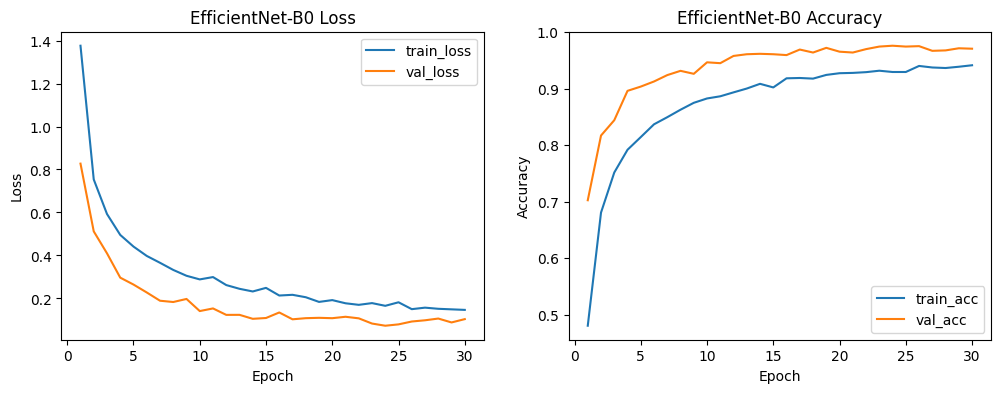

In [9]:
plot_history(history, model_name="EfficientNet-B0")


In [10]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


In [11]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.92      0.91      0.91        86
             Chickenpox       0.98      0.96      0.97       112
                 Cowpox       0.99      1.00      0.99        99
         Dermatofibroma       0.92      0.96      0.94        23
                   HFMD       0.99      0.99      0.99       241
                Healthy       0.97      0.99      0.98       171
                Measles       0.99      0.99      0.99        82
              Monkeypox       0.99      0.98      0.99       426
Squamous cell carcinoma       0.87      0.87      0.87        62
       Vascular lesions       1.00      1.00      1.00        25

               accuracy                           0.98      1327
              macro avg       0.96      0.97      0.96      1327
           weighted avg       0.98      0.98      0.98      1327

Confusion matrix:
 [[ 78   0   0   0   0   0   0   0   8   0]
 [  0 108   0   0   0   0

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 1337
Loaded checkpoint: EfficientNet-B0_best.pth
                         precision    recall  f1-score   support

      Actinic keratoses       0.88      0.88      0.88        88
             Chickenpox       1.00      0.98      0.99       113
                 Cowpox       1.00      0.98      0.99        99
         Dermatofibroma       0.96      0.88      0.92        25
                   HFMD       0.99      0.99      0.99       242
                Healthy       0.99      0.99      0.99       171
                Measles       0.97      1.00      0.98        83
              Monkeypox       0.99      0.99      0.99       426
Squamous cell carcinoma       0.84      0.88      0.85        64
       Vascular lesions       0.96      0.96     

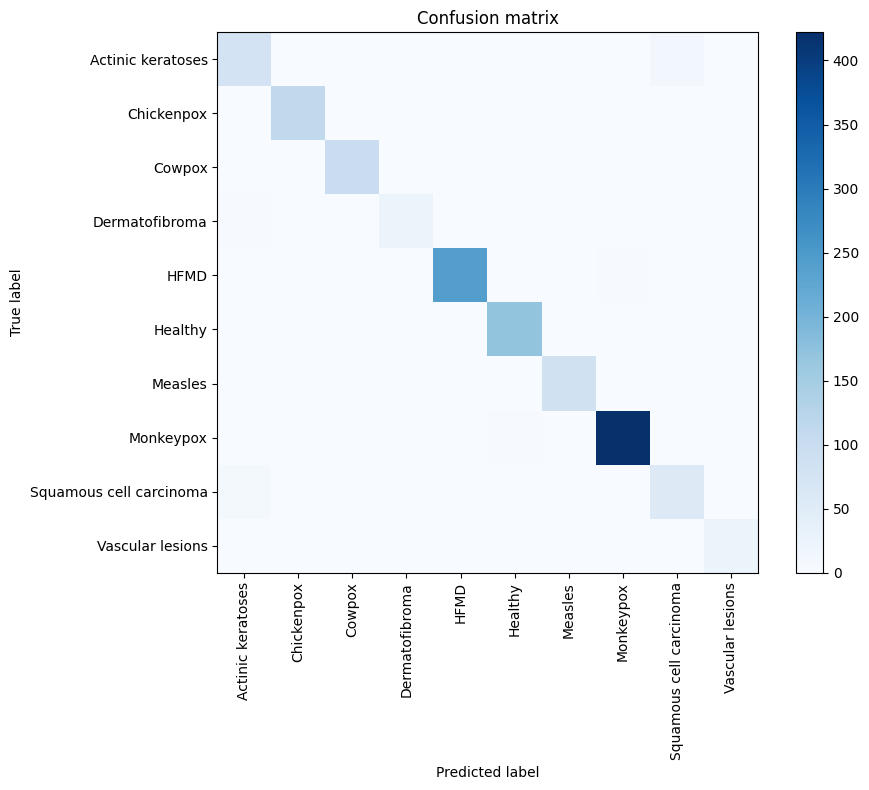

Saved test_predictions.csv


In [12]:

%pip install pandas
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# path to test data 
test_dir = r"D:\archive\test"   

# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# load best checkpoint (if you saved it during training)
ckpt_path = "EfficientNet-B0_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("Loaded checkpoint:", ckpt_path)
except Exception as e:
    print("Checkpoint load failed (using current model):", e)

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# optional: plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=90)
plt.yticks(tick_marks, test_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# optional: save per-image predictions (filenames, true, pred, prob)
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": filenames,
    "true": [test_dataset.classes[i] for i in y_true],
    "pred": [test_dataset.classes[i] for i in y_pred],
    "prob_top": [round(float(np.max(p)),4) for p in probs]
})
df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")

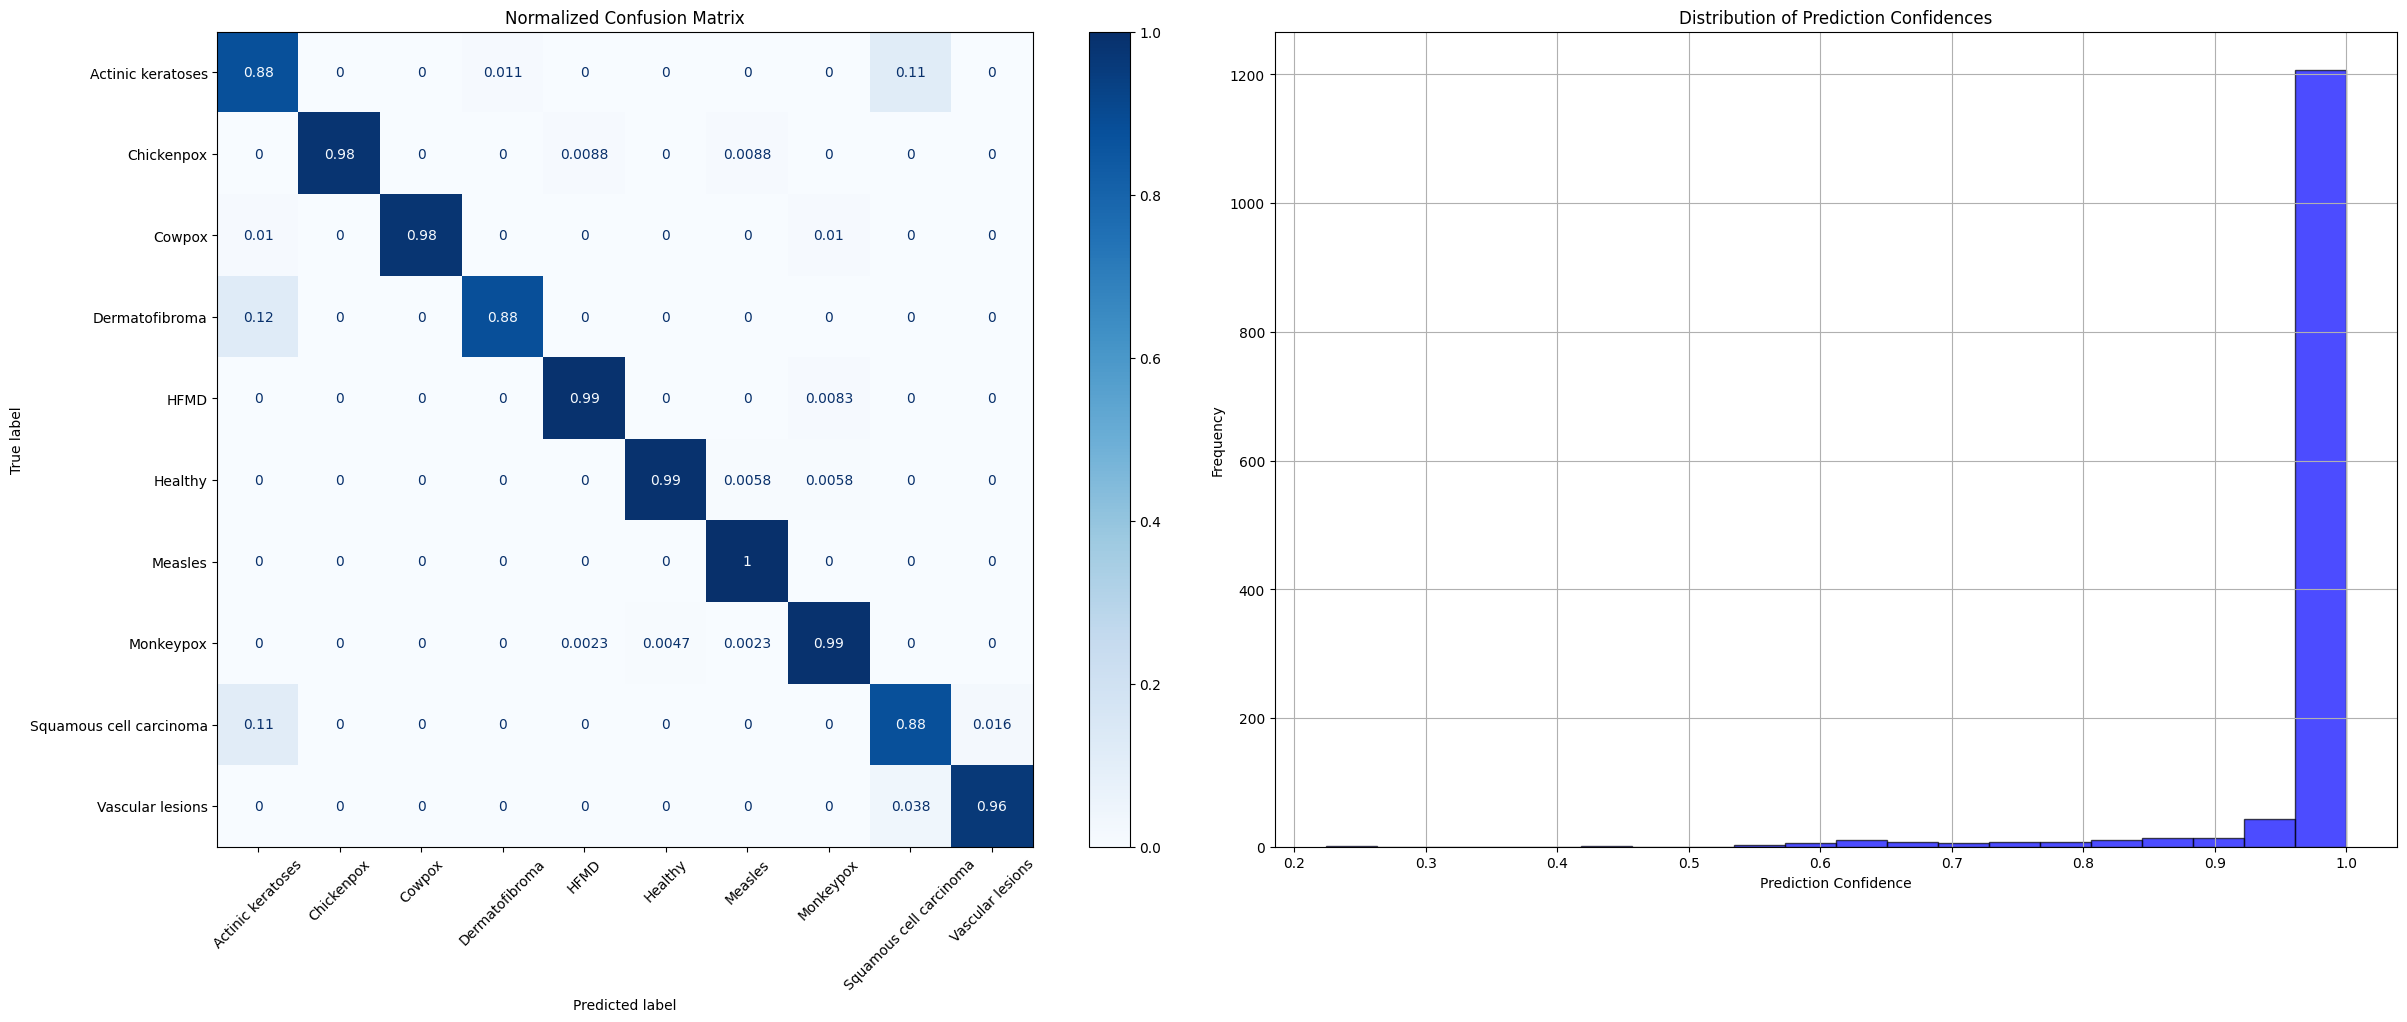

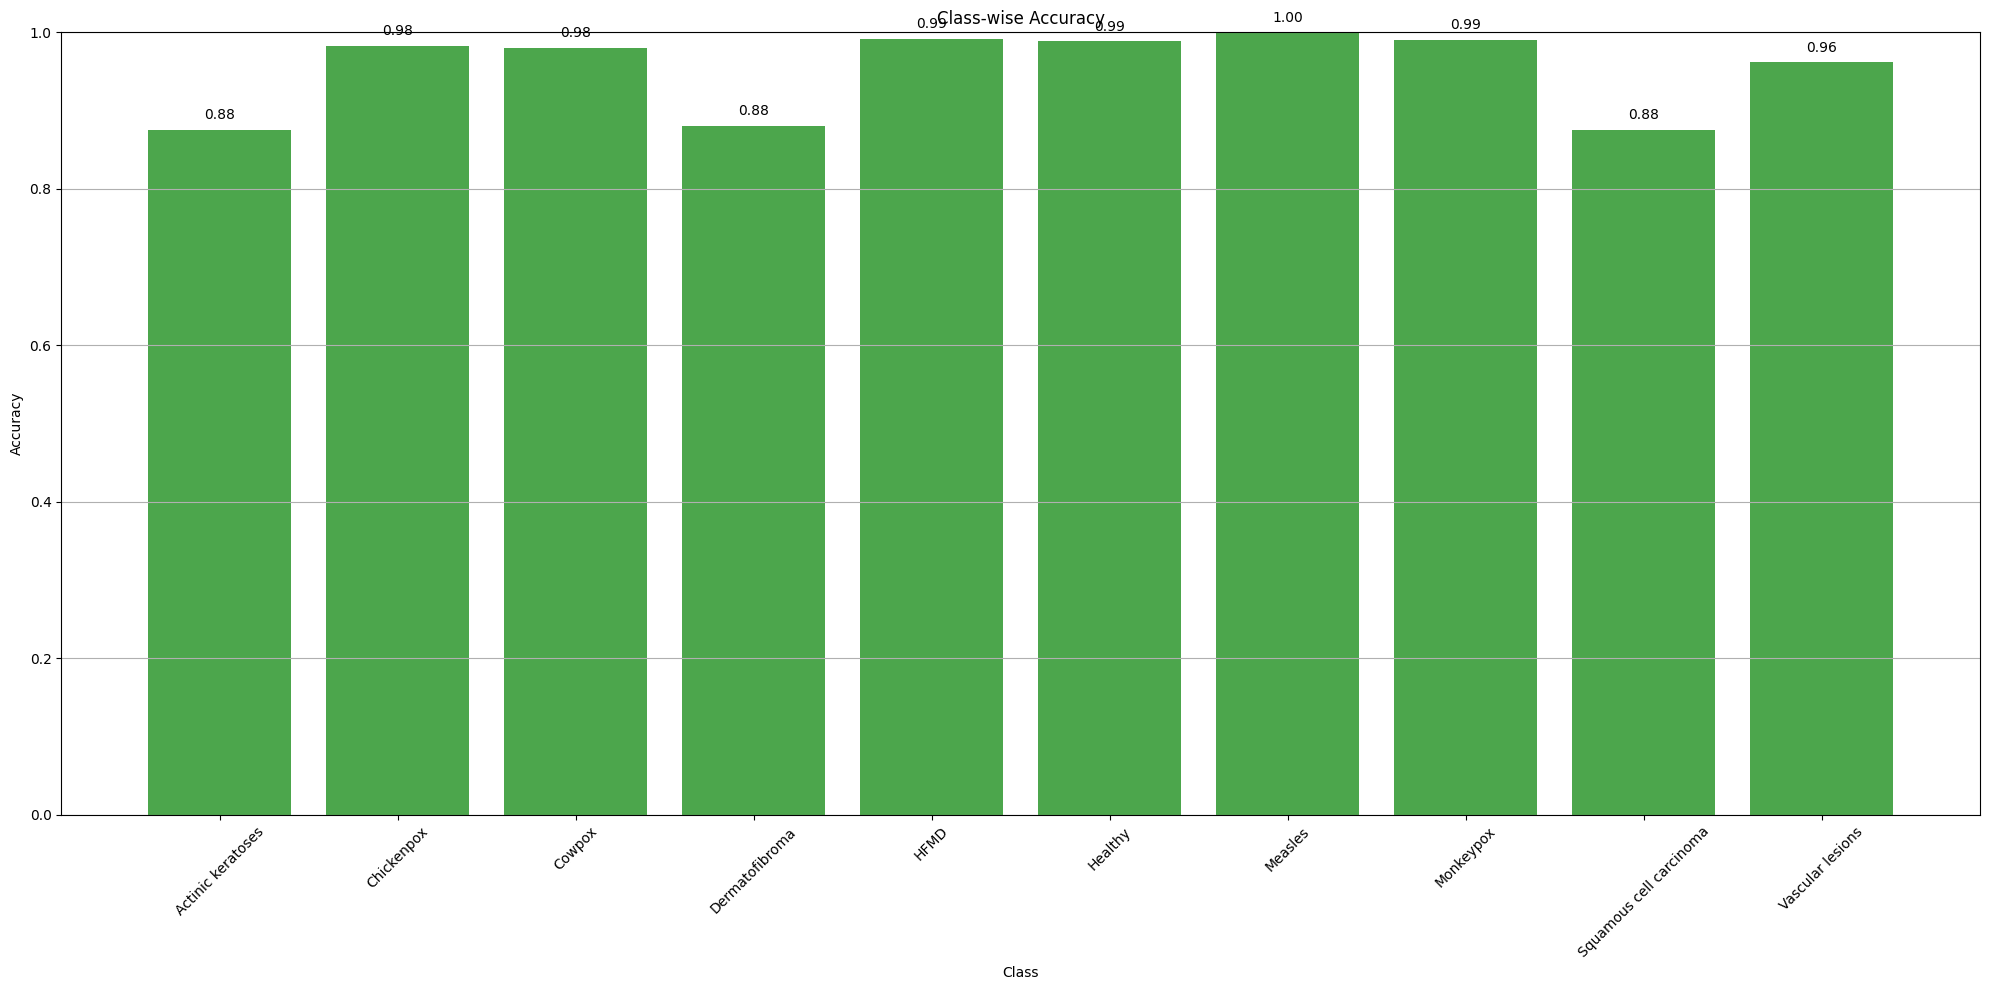

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Assuming class_names is available from earlier cells

# 1. Confusion Matrix and Histogram side by side (2 per row)
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Enhanced Confusion Matrix (left)
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=axes[0], xticks_rotation=45)
axes[0].set_title('Normalized Confusion Matrix')

# Histogram of Prediction Confidences (right)
top_probs = [np.max(p) for p in probs]
axes[1].hist(top_probs, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_xlabel('Prediction Confidence')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Confidences')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 2. Class-wise Accuracy as separate plot
plt.figure(figsize=(20, 10))
class_accuracies = []
for i in range(len(class_names)):
    mask = np.array(y_true) == i
    if np.sum(mask) > 0:
        acc = np.mean(np.array(y_pred)[mask] == i)
    else:
        acc = 0
    class_accuracies.append(acc)

plt.bar(range(len(class_names)), class_accuracies, color='green', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, v in enumerate(class_accuracies):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

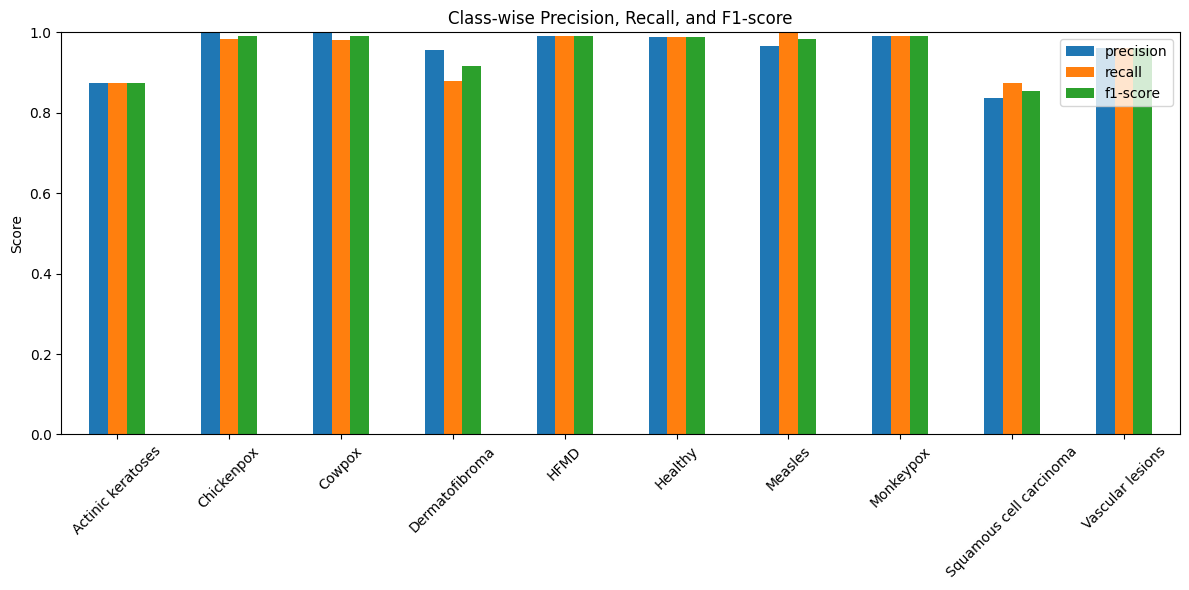

In [15]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Compute report as DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3, :]  # remove avg rows

plt.figure(figsize=(10,6))
df_report[['precision','recall','f1-score']].plot(kind='bar', figsize=(12,6))
plt.title("Class-wise Precision, Recall, and F1-score")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

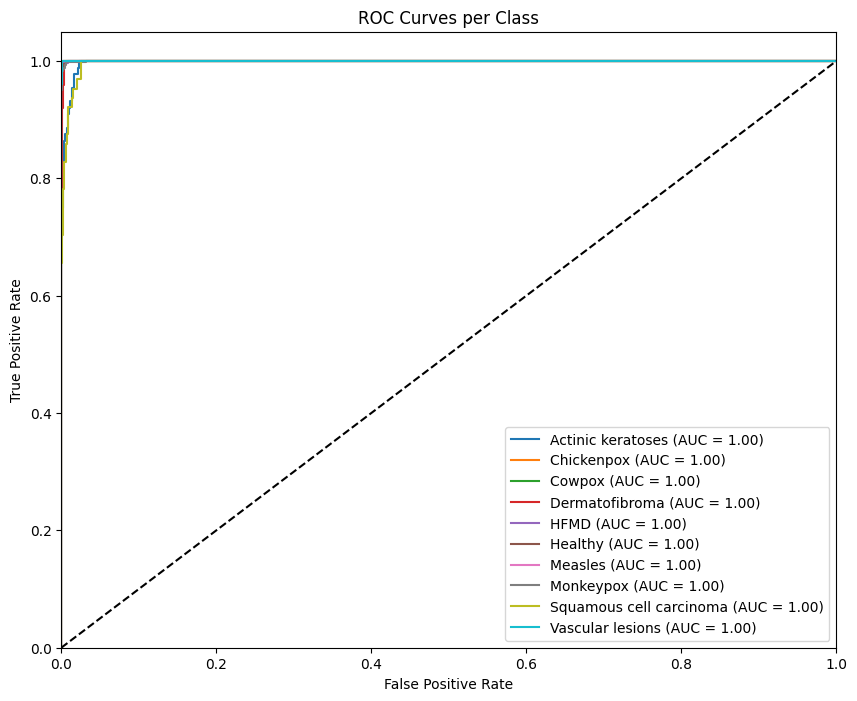

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
y_pred_prob = np.array(probs)  # shape (n_samples, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc="lower right")
plt.show()

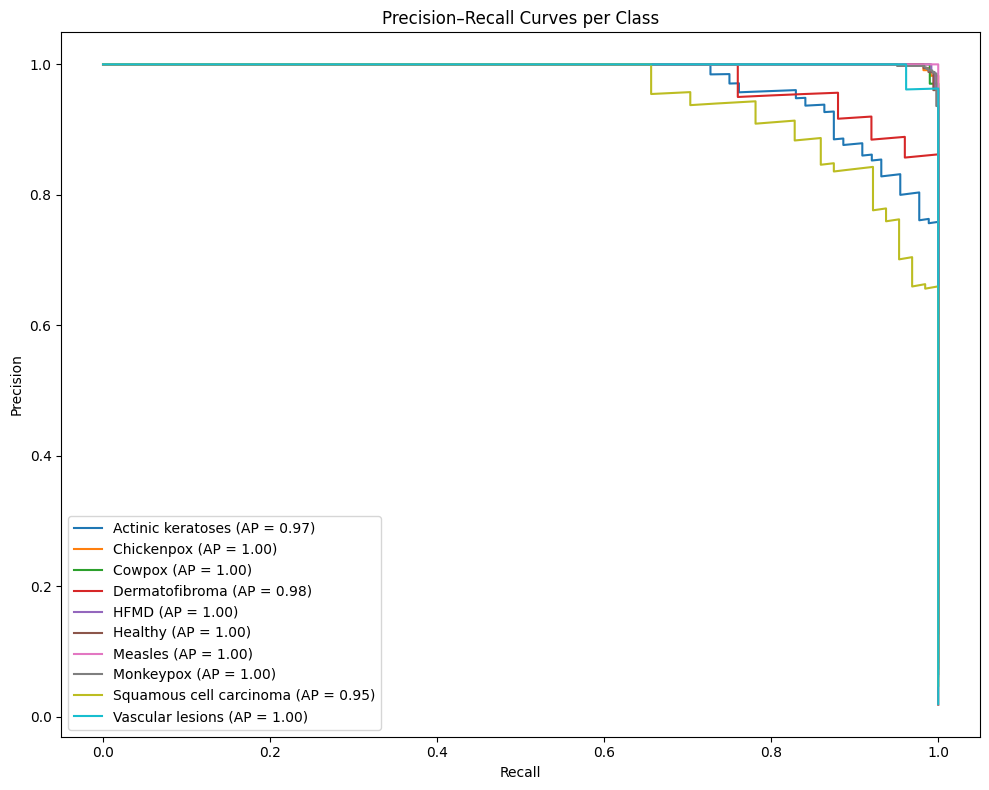

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')

plt.title("Precision–Recall Curves per Class")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
import cv2
from torch.nn import functional as F
from PIL import Image

# Grad-CAM for EfficientNet (last conv block)
def gradcam_visualize(model, img_path, target_layer="features"):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    input_tensor = val_transforms(image).unsqueeze(0).to(device)

    grad = None
    fmap = None

    def forward_hook(module, input, output):
        nonlocal fmap
        fmap = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal grad
        grad = grad_out[0]

    # Clear any existing hooks to avoid conflicts
    for module in model.modules():
        if hasattr(module, '_backward_hooks'):
            module._backward_hooks.clear()
        if hasattr(module, '_forward_hooks'):
            module._forward_hooks.clear()
        module._is_full_backward_hook = None

    # Attach hooks to the target layer
    layer = dict([*model.named_modules()])[target_layer]
    forward_handle = layer.register_forward_hook(forward_hook)
    backward_handle = layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    pred = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    output[:, pred].backward()

    # Compute Grad-CAM
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * fmap).sum(dim=1).squeeze()

    # Detach before converting to numpy
    cam = cam.detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (224, 224))

    # Overlay heatmap on original image
    img = np.array(image.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM: {class_names[pred]}")
    plt.axis("off")
    plt.show()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

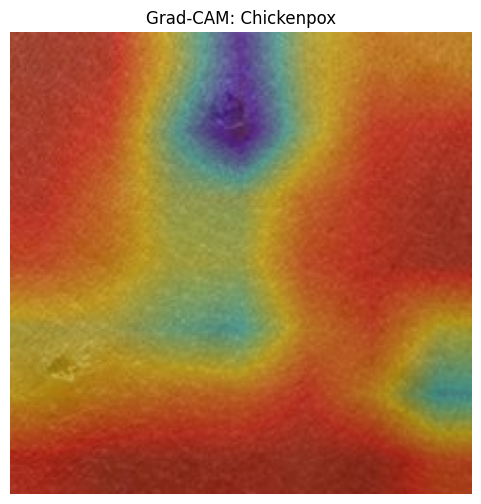

In [41]:
gradcam_visualize(model, r"D:\archive\test\Chickenpox\CHP_02_01_8.jpg")

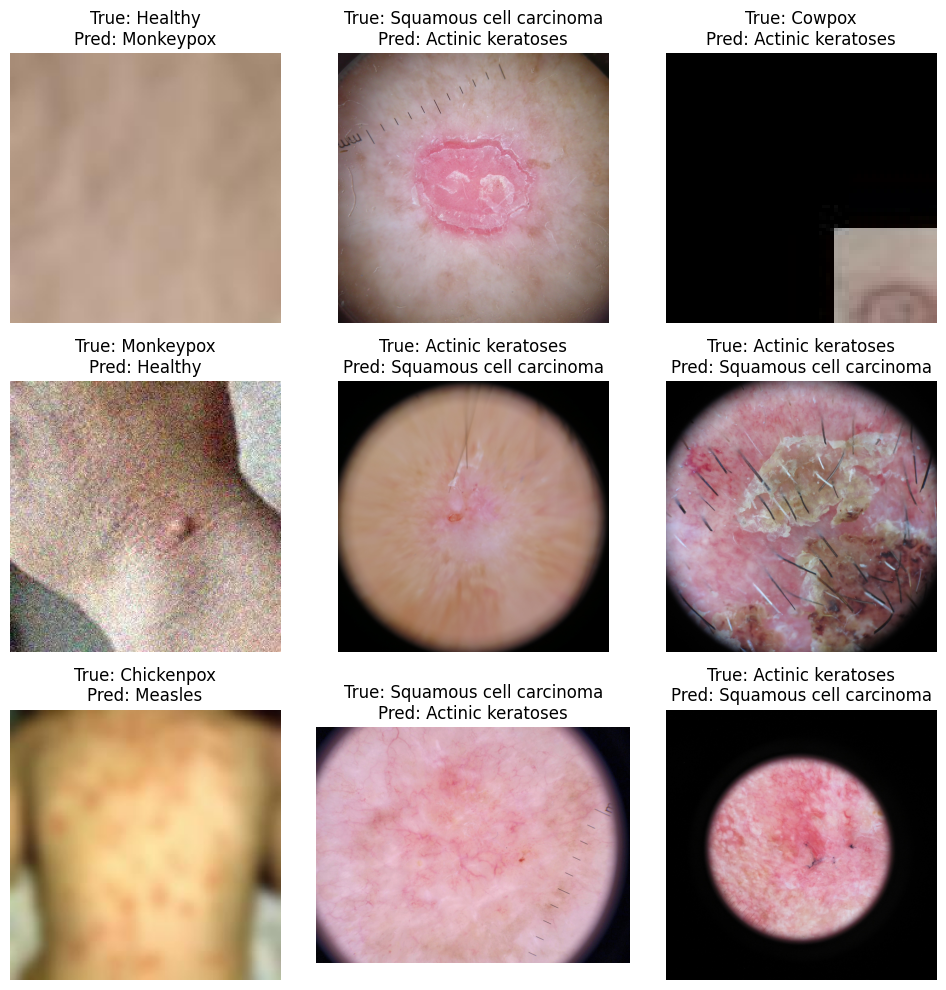

In [23]:
import random

misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
sample_indices = random.sample(misclassified_indices, min(9, len(misclassified_indices)))

plt.figure(figsize=(10,10))
for idx, i in enumerate(sample_indices):
    img_path = test_dataset.samples[i][0]
    img = Image.open(img_path)
    plt.subplot(3,3,idx+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

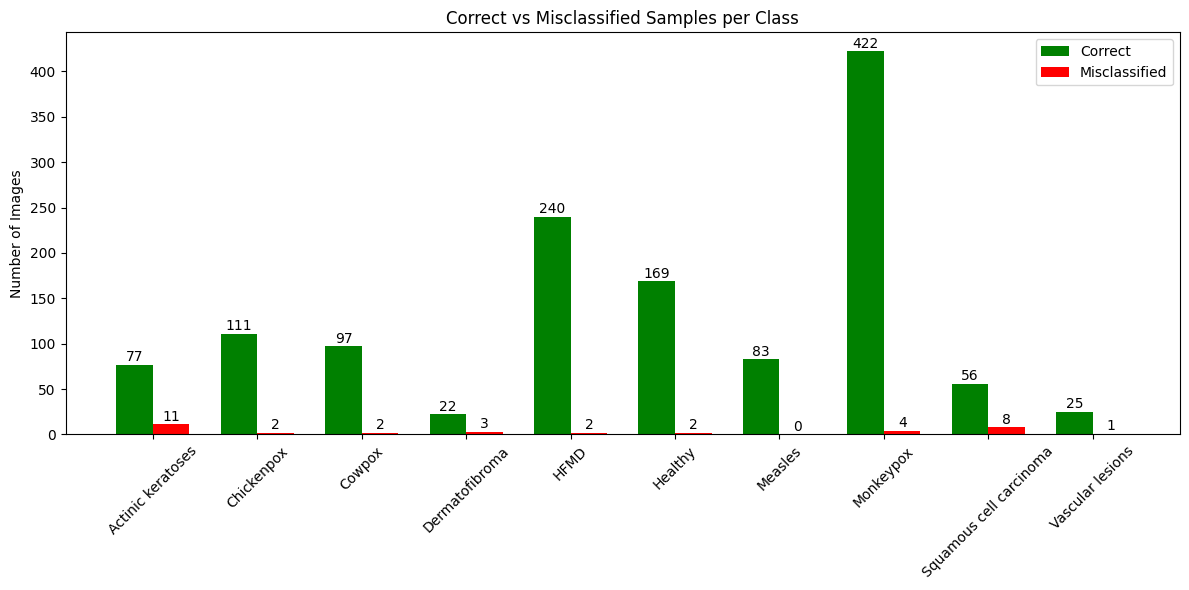

In [24]:
# Total samples per class
total_per_class = np.zeros(len(class_names))
correct_per_class = np.zeros(len(class_names))
misclassified_per_class = np.zeros(len(class_names))

for i, cls_idx in enumerate(y_true):
    total_per_class[cls_idx] += 1
    if y_true[i] == y_pred[i]:
        correct_per_class[cls_idx] += 1
    else:
        misclassified_per_class[cls_idx] += 1

# Plotting
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(12,6))
bars_correct = plt.bar(x - width/2, correct_per_class, width, label='Correct', color='green')
bars_misclassified = plt.bar(x + width/2, misclassified_per_class, width, label='Misclassified', color='red')

# Add counts on top of bars
for bar in bars_correct:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)

for bar in bars_misclassified:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.xticks(x, class_names, rotation=45)
plt.ylabel("Number of Images")
plt.title("Correct vs Misclassified Samples per Class")
plt.legend()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.68244..1.1700488].


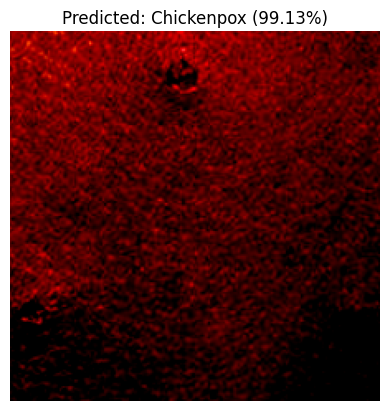

In [28]:
# Load the best model for inference
from PIL import Image
from torchvision.models import EfficientNet_B0_Weights
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model.load_state_dict(torch.load('EfficientNet-B0_best.pth'))
model = model.to(device)
model.eval()

# Function to predict single image
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
        predicted_label = class_names[predicted.item()]
        confidence = confidence.item()
    return predicted_label, confidence, image.squeeze(0).cpu()

# Example prediction
test_image_path = r"D:\archive\test\Chickenpox\CHP_02_01_8.jpg"  # Replace with actual path
predicted_label, confidence, img_tensor = predict_image(test_image_path, model, val_transforms)

# Display image with prediction
plt.imshow(img_tensor.permute(1,2,0))
plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()